# Demonstration section

In [50]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [51]:
plt.style.use('seaborn-whitegrid')
font={'family':'Helvetica',
      'weight':'bold',
      'size':14}

mpl.rc('font',**font)

effective_size = sms.proportion_effectsize(0.13,0.15) # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effective_size,power=0.8,alpha=0.05,ratio=1
) # Calculating sample size needed

required_n = ceil(required_n)

print(required_n)

4720


In [52]:
df = pd.read_csv('/content/drive/MyDrive/ML 60 DAYS/ab_data.csv')

In [53]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [55]:
# Find repeated values
session_counts = df['user_id'].value_counts(ascending=True)
multi_users = session_counts[session_counts>1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [56]:
# Remove repeated values

users_to_drop = session_counts[session_counts>1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [57]:
# control experiment 5:5 4720*2=9440

control_sample = df[df['group'] == 'control'].sample(n=required_n,random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n,random_state=22)

ab_test = pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [58]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [59]:
ab_test['group'].value_counts() # 1:1

treatment    4720
control      4720
Name: group, dtype: int64

In [60]:
conversion_rate = ab_test.groupby('group')['converted']

std_p = lambda x:np.std(x,ddof=0)
se_p = lambda x:stats.sem(x,ddof=0)

conversion_rates = conversion_rate.agg([np.mean,std_p,se_p])
conversion_rates.columns = ['conversion_rate','std_deviation','std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


In [61]:
conversion_rate.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,4720.0,0.123305,0.328822,0.0,0.0,0.0,0.0,1.0
treatment,4720.0,0.125636,0.331473,0.0,0.0,0.0,0.0,1.0


Text(0, 0.5, 'Converted (proportion)')

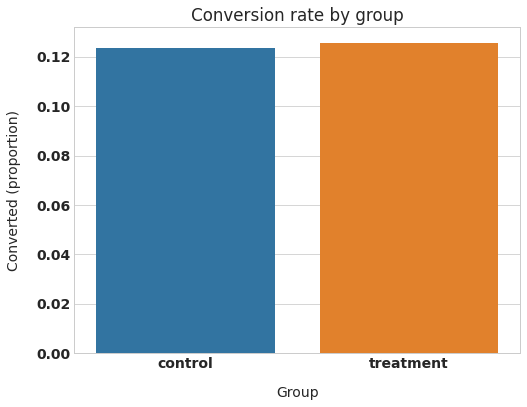

In [62]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test.group,y=ab_test.converted,ci=False)

# plt.ylim(0,0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group',labelpad=15)
plt.ylabel('Converted (proportion)',labelpad=15)

In [63]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group']=='control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(),treatment_results.sum()]
nobs=[n_con,n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


# Below is for (0.12, 0.11)



In [72]:
plt.style.use('seaborn-whitegrid')
font={'family':'Helvetica',
      'weight':'bold',
      'size':14}

mpl.rc('font',**font)

effective_size = sms.proportion_effectsize(0.12,0.11) # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effective_size,power=0.8,alpha=0.05,ratio=1
) # Calculating sample size needed

required_n = ceil(required_n)

print(required_n)

15970


In [74]:
df = pd.read_csv('/content/drive/MyDrive/ML 60 DAYS/ab_data.csv')

In [75]:
session_counts = df['user_id'].value_counts(ascending=True)
multi_users = session_counts[session_counts>1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [76]:
users_to_drop = session_counts[session_counts>1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [77]:
# control experiment 5:5 4720*2=9440

control_sample = df[df['group'] == 'control'].sample(n=required_n,random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n,random_state=22)

ab_test = pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
31935,780954,2017-01-19 07:49:58.295232,treatment,new_page,0
31936,700881,2017-01-13 12:31:37.243352,treatment,new_page,0
31937,829626,2017-01-14 09:07:57.784950,treatment,new_page,0
31938,773197,2017-01-05 00:23:56.177295,treatment,new_page,0


In [78]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31940 entries, 0 to 31939
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       31940 non-null  int64 
 1   timestamp     31940 non-null  object
 2   group         31940 non-null  object
 3   landing_page  31940 non-null  object
 4   converted     31940 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [79]:
ab_test['group'].value_counts() # 1:1

treatment    15970
control      15970
Name: group, dtype: int64

In [80]:
conversion_rate = ab_test.groupby('group')['converted']

std_p = lambda x:np.std(x,ddof=0)
se_p = lambda x:stats.sem(x,ddof=0)

conversion_rates = conversion_rate.agg([np.mean,std_p,se_p])
conversion_rates.columns = ['conversion_rate','std_deviation','std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.003
treatment,0.121,0.326,0.003


In [ ]:
conversion_rate.describe()

Text(0, 0.5, 'Converted (proportion)')

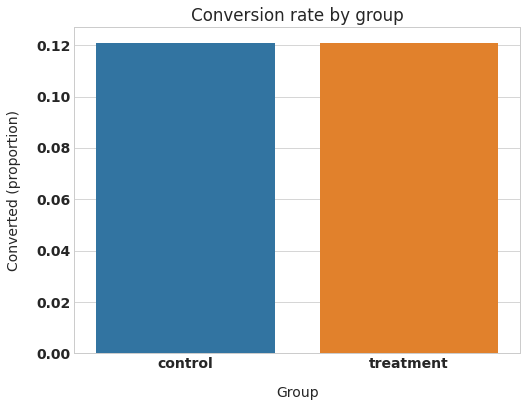

In [81]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test.group,y=ab_test.converted,ci=False)

# plt.ylim(0,0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group',labelpad=15)
plt.ylabel('Converted (proportion)',labelpad=15)

In [82]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group']=='control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(),treatment_results.sum()]
nobs=[n_con,n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.07
p-value: 0.945
ci 95% for control group: [0.116, 0.126]
ci 95% for treatment group: [0.116, 0.126]


In [ ]:
# Conclusion

# z-stat is no larger than z-crit 1.96, and the null hypthesis is not rejected
# p-value is no smaller than alpha 0.05, and the null hypthesis is not rejected
# 0.12 is included but 0.11 is not included
# Treatment group cannot be adopted